
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2024**

---

### Proyecto de Mentoria: 
### Predicción del tránsito en la Ciudad de Córdoba, aportes para la construcción de un mapa de ruido

---

# Práctico Nº2 - Análisis exploratorio y curación de datos


## Introducción

El análisis exploratorio de los datos nos permitirá haber identificado valores faltantes y tomar acciones sobre ellos. ¿Estos datos serán suprimidos del dataset?, si no se eliminan, ¿serán imputados? ¿de qué forma y con qué criterio?. ¿Existen datos duplicados en el dataset? El análisis de los outliers es encesario para comprender si realmente son atípicos o son casos excepcionales que deben tenerse en cuenta. ¿Qué porcentaje representan? ¿Los serán eliminamos o se mantiene cierto porcentaje de ellos y con qué criterio?

La inspección de las variables disponibles nos permitirá responder: ¿todos los datos son relevantes para el problema o podemos prescindir de algunos? ¿Será necesario incorporar otros datos para una mejor comprensión del problema? ¿Será posible clasificar el flujo vehicular a grandes rasgos? El estudio de estas preguntas posibilitará generar nuevas variables y/o incorporar variables externas al dataset.

Por último se deben aplicar transformación sobre los datos existentes, como normalización, estandarización, encoding numérico sobre variables categóricas, etc., para dejar el dataset en condiciones para su modelado.

## Paquetes de Python y Setup

Se importan los paquetes necesarios para este notebook
- *pandas*
- *matplotlib*
- *seaborn*
- *numpy*
- *KNNImputer*
- *drive*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

Se configuran los siguientes módulos
- Cambio del estilo gráfico de Matplotlib
- Asignación de una paleta de colores
- Configuración de Pandas para mostrar 100 filas y 50 columnas

In [2]:
plt.style.use('ggplot')
color = sns.color_palette()
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

## Creación del Dataframe

Se crea el dataframe del archivo `output.csv` creado en el trabajo anterior

In [3]:
df = pd.read_csv('Data/output.csv', delimiter=';')

Se crea una función que preprocesa los datos. Los cambios que realiza son:
- Cambios en los nombres de las columnas
- Extraer la hora de un cadena
- Establecer la fecha como tipo `datetime`
- Resetear el índice
- Acomodar columnas

In [4]:
def preprocess_data(df):
    df.rename(columns={'vehiculos': 'traffic_flow', 'turno': 'period_of_day'}, inplace=True)

    df['hora'] = df['IntervaloSegmento'].str.split(' a ').str[1].str.split(' hs.').str[0]
    df['hora'] = pd.to_datetime(df['hora'], format='%H:%M').dt.time

    df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')

    df['datetime'] = pd.to_datetime(df['fecha'].astype(str) + ' ' + df['hora'].astype(str))
    df.set_index('datetime', inplace=True)

    df.drop(columns=['fecha', 'hora', 'IntervaloSegmento', 'periodo', 'diaSemana'], inplace=True)

    return df

También se crea otra función que gebera las demás columnas del dataframe a partir del dataframe con los datos preprocesados

In [5]:
def create_feature(df):
    df = df.copy(deep=True)
    df = preprocess_data(df)
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day'] = df.index.day

    column_order = [
        'year', 'month', 'day', 'day_of_year',
        'day_of_week', 'hour', 'minute', 'period_of_day',
        'traffic_flow']

    df = df[column_order]
    df = df.sort_index()

    return df

Se crea el nuevo dataframe **traffic_flow** mediante las funciones creadas

In [6]:
traffic_flow = create_feature(df)

In [7]:
traffic_flow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160699 entries, 2019-08-01 00:00:00 to 2024-02-29 23:45:00
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   year           160699 non-null  int32 
 1   month          160699 non-null  int32 
 2   day            160699 non-null  int32 
 3   day_of_year    160699 non-null  int32 
 4   day_of_week    160699 non-null  int32 
 5   hour           160699 non-null  int32 
 6   minute         160699 non-null  int32 
 7   period_of_day  160699 non-null  object
 8   traffic_flow   160699 non-null  int64 
dtypes: int32(7), int64(1), object(1)
memory usage: 8.0+ MB


## Datos faltantes

Con el dataframe con los datos originales sin imputar se puede crear un grafico por año para observar como se comporta la variable `traffic_flow`

**Aclaración:** `sns.lineplot()` genera un gráfico con el promedio de `traffic_flow` por día, es decir, los gráficos mostrados van del día 1 al 365 de cada año

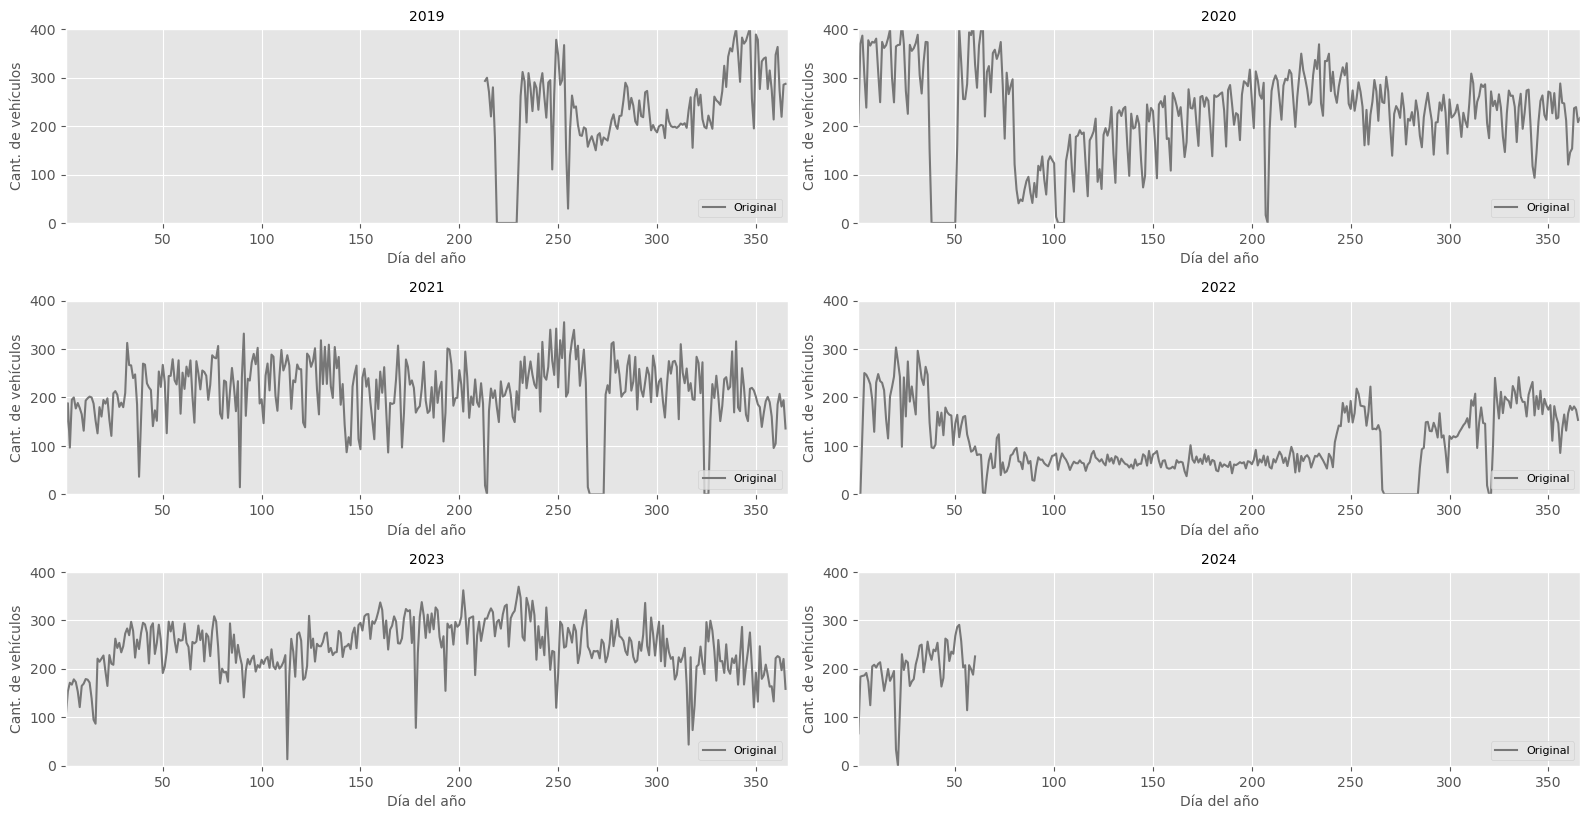

In [8]:
plt.figure(figsize=(16, 16))
for i, year in enumerate(range(2019, 2025)):
    plt.subplot(6, 2, i + 1)
    sns.lineplot(
        data=traffic_flow[traffic_flow.index.year == year],
        x=traffic_flow[traffic_flow.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Original',
        color=color[3]
        )
    plt.ylim(0, 400)
    plt.xlim(1, 366)
    plt.ylabel('Cant. de vehículos', fontsize=10)
    plt.xlabel('Día del año', fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

    plt.title(f'{year}', fontsize=10)
plt.tight_layout()
plt.show()

Es notorio la cantidad de datos faltantes en la serie temporal. Si bien hay zonas donde la cantidad de vehículos no llega a cero, esto tambien corresponde con un dato faltantes ya que el grafico dibuja las lineas por día y cada día tiene 96 entradas (4 mediciones por hora), es decir, pondera los datos por día

In [11]:
null_index = traffic_flow[traffic_flow['traffic_flow'] == 0].index
print(f'Cantidad de datos faltantes: {len(null_index)}')
print(f'Porcentaje de datos faltantes: {((len(null_index))/len(traffic_flow.index)*100):.2f}%')

Cantidad de datos faltantes: 10557
Porcentaje de datos faltantes: 6.57%


Se puede obtener la cantidad de datos faltantes por año

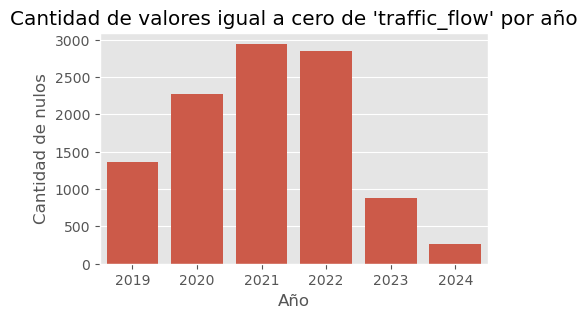

In [10]:
nulos_por_año = traffic_flow[traffic_flow['traffic_flow'] == 0].groupby('year').size().reset_index(name='cantidad_nulos')

plt.figure(figsize=(5, 3))
sns.barplot(data=nulos_por_año, x='year', y='cantidad_nulos')
plt.title("Cantidad de valores igual a cero de 'traffic_flow' por año")
plt.xlabel('Año')
plt.ylabel('Cantidad de nulos')
plt.show()

Para imputar los datos faltantes se crea una copia del dataframe original reemplazando los valores igual a cero por Nan

In [12]:
traffic_flow_nan = traffic_flow.copy(deep=True)

In [13]:
traffic_flow_nan['traffic_flow'] = traffic_flow_nan['traffic_flow'].replace(0, np.nan)

In [14]:
traffic_flow_nan.isna().sum()

year                 0
month                0
day                  0
day_of_year          0
day_of_week          0
hour                 0
minute               0
period_of_day        0
traffic_flow     10557
dtype: int64

### Imputación mediante la media de los valores

La primera forma de imputar los datos es mediante la **media**. En el trabajo anterior se determino mediante los mapas de calor cuales eran los días y horarios con mayor y menor cantidad de vehículos. A partir de esto, teniendo las columnas `year`, `day_of_week` y `period_of_day`, se procede a obtener la media

In [15]:
mean_traffic_flow = traffic_flow_nan.groupby(['year', 'day_of_week', 'period_of_day'])['traffic_flow'].mean().reset_index()
mean_traffic_flow['traffic_flow'] = mean_traffic_flow['traffic_flow'].round()
mean_traffic_flow = mean_traffic_flow.rename(columns={'traffic_flow': 'mean_traffic_flow'})
mean_traffic_flow.head()

,year,day_of_week,period_of_day,mean_traffic_flow
0,2019,0,madrugada,138.0
1,2019,0,mañana,339.0
2,2019,0,noche,230.0
3,2019,0,siesta,338.0
4,2019,0,tarde,303.0


Se crea un diccionario con los valores obtenidos y una función que reemplaza estos valores

In [16]:
means_dict = mean_traffic_flow.set_index(['year', 'day_of_week', 'period_of_day'])['mean_traffic_flow'].to_dict()

In [17]:
def replace_nan(row):
    if pd.isna(row['traffic_flow']):
        return means_dict.get((row['year'], row['day_of_week'], row['period_of_day']), row['traffic_flow'])
    else:
        return row['traffic_flow']

Se crea una copia del dataframe original

In [18]:
traffic_flow_mean = traffic_flow_nan.copy(deep=True)

Se utiliza la función para reemplaza los valores nulos

In [19]:
traffic_flow_mean['traffic_flow'] = traffic_flow_mean.apply(replace_nan, axis=1)

Se crea un grafico comparandolo con el gráfico original

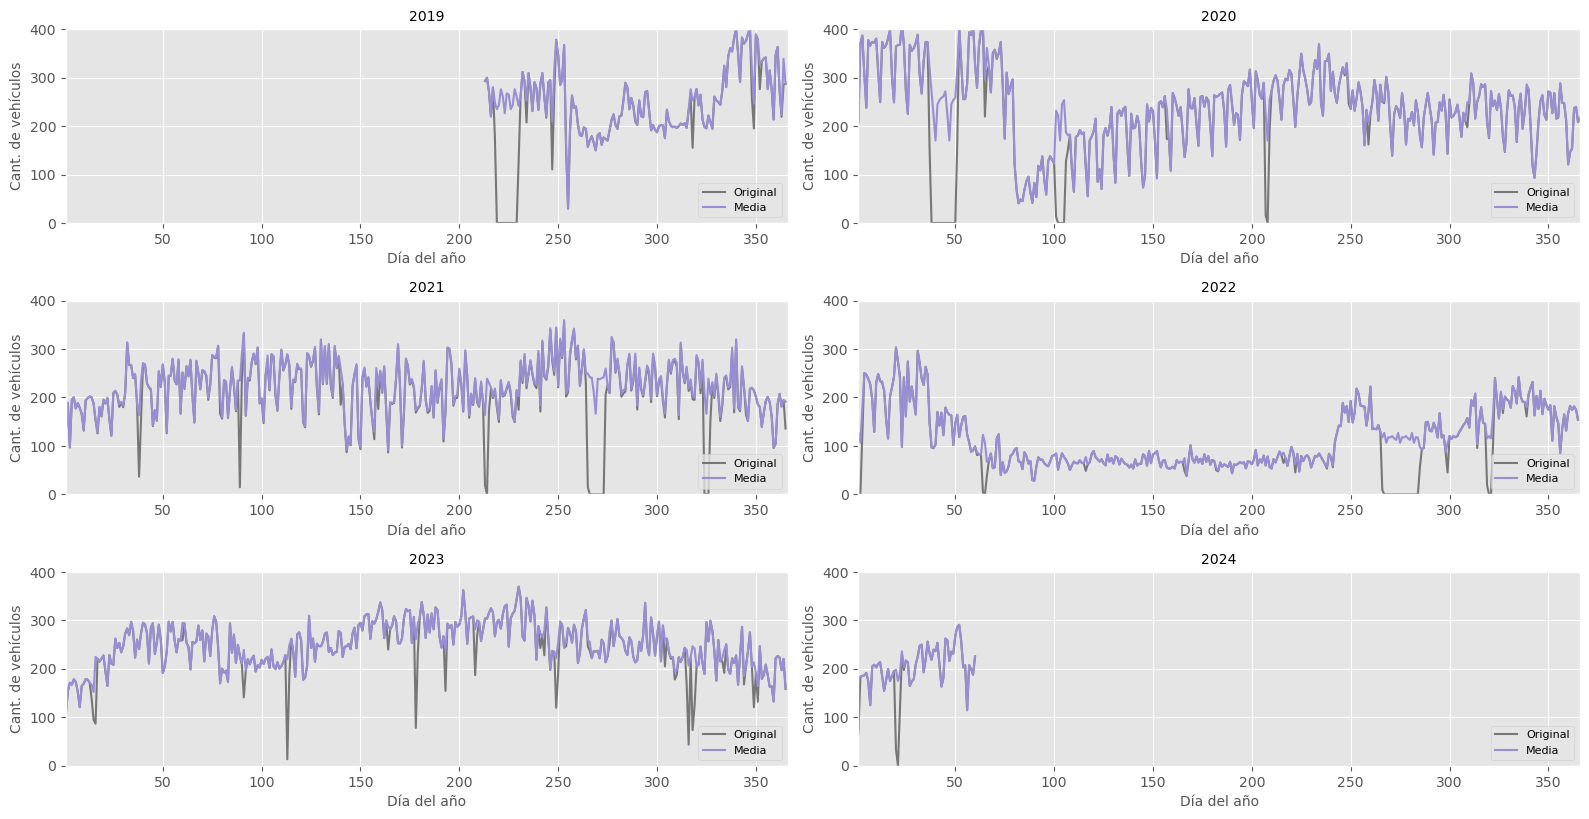

In [20]:
plt.figure(figsize=(16, 16))
for i, year in enumerate(range(2019, 2025)):
    plt.subplot(6, 2, i + 1)
    sns.lineplot(
        data=traffic_flow[traffic_flow.index.year == year],
        x=traffic_flow[traffic_flow.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Original',
        color=color[3]
        )
    sns.lineplot(
        data=traffic_flow_mean[traffic_flow_mean.index.year == year],
        x=traffic_flow_mean[traffic_flow_mean.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Media',
        color=color[2]
        )
    plt.ylim(0, 400)
    plt.xlim(1, 366)
    plt.ylabel('Cant. de vehículos', fontsize=10)
    plt.xlabel('Día del año', fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

    plt.title(f'{year}', fontsize=10)
plt.tight_layout()
plt.show()

Imputar mediante la media para este caso funciona bastante bien, reemplazando los valores nulos y viendo que sigue una linea de tendencia con respecto a cada años. Pero en el 2020, donde fue un año atípico, se pueden ver dos tendencias de trafico que mediante la media de los valores no se puede seguir de manera uniforme

### Imputación mediante KNN

Ahora se plantea utilizar la imputación mediante KNN vecinos cercanos que utiliza la proximidad para hacer clasificaciones sobre la agrupación de un punto de datos individual

Para este metodo tenemos dos opciones sobre que columnas imputar:
- Usar solo algunas columnas: al limitar las columnas, puedes enfocarte en las que son más relevantes para la imputación, reduciendo el ruido. Sin embargo, también podrías perder información valiosa que podría mejorar la imputación
- Usar todas las columnas: al incluir todas las columnas, el KNNImputer tiene más información para determinar los valores faltantes, lo que puede conducir a imputaciones más precisas. Sin embargo, esto también puede incluir ruido o información irrelevante

Primero se seleccionaran las columnas más relevantes, para esto se crea una copia del dataframe original

In [21]:
traffic_flow_knn_1 = traffic_flow_nan.copy(deep=True)

Se imputan los valores indicandole que columnas debe tener en cuenta para el proceso de imputación

In [22]:
imputer_1 = KNNImputer(n_neighbors=5)
imputed_columns = ['year', 'month', 'day_of_week', 'hour', 'minute', 'traffic_flow']
traffic_flow_knn_1[imputed_columns] = imputer_1.fit_transform(traffic_flow_knn_1[imputed_columns])

Para la otra imputación se seleccionan todas las columnas, menos las tipo `object`

In [23]:
traffic_flow_knn_2 = traffic_flow_nan.copy(deep=True)

In [24]:
imputer_2 = KNNImputer(n_neighbors=5)
imputed_columns_2 = traffic_flow_knn_2.select_dtypes(exclude=['object']).columns.tolist()
traffic_flow_knn_2[imputed_columns_2] = imputer_2.fit_transform(traffic_flow_knn_2[imputed_columns_2])

Para poder comparar los resultados se los compara con los valores originales

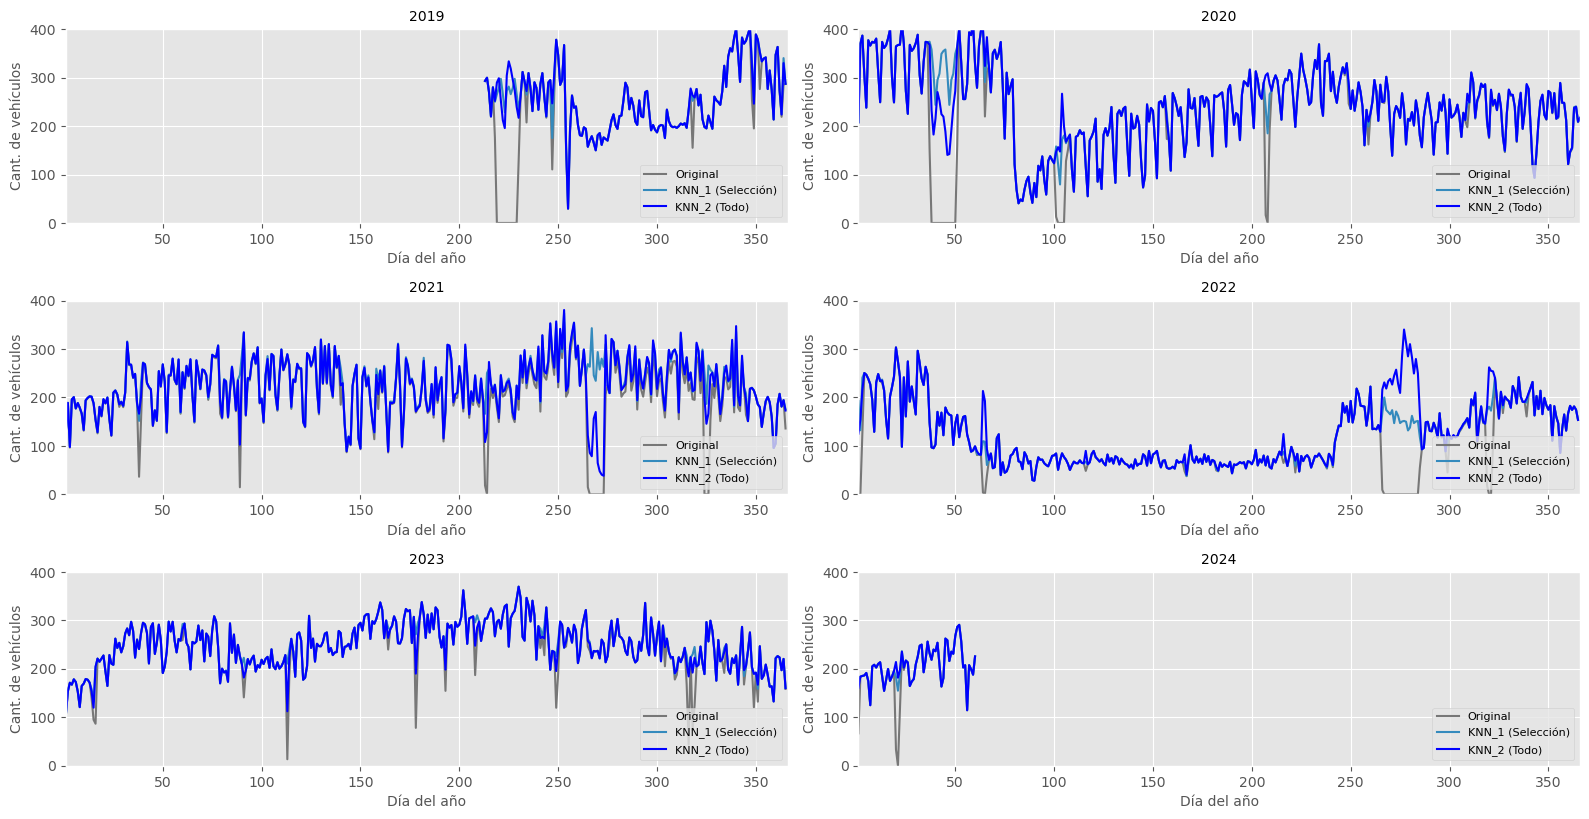

In [25]:
plt.figure(figsize=(16, 16))
for i, year in enumerate(range(2019, 2025)):
    plt.subplot(6, 2, i + 1)
    sns.lineplot(
        data=traffic_flow[traffic_flow.index.year == year],
        x=traffic_flow[traffic_flow.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Original',
        color=color[3]
        )
    sns.lineplot(
        data=traffic_flow_knn_1[traffic_flow_knn_1.index.year == year],
        x=traffic_flow_knn_1[traffic_flow_knn_1.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='KNN_1 (Selección)',
        color=color[1]
        )
    sns.lineplot(
        data=traffic_flow_knn_2[traffic_flow_knn_2.index.year == year],
        x=traffic_flow_knn_2[traffic_flow_knn_2.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='KNN_2 (Todo)',
        color='blue'
        )
    plt.ylim(0, 400)
    plt.xlim(1, 366)
    plt.ylabel('Cant. de vehículos', fontsize=10)
    plt.xlabel('Día del año', fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

    plt.title(f'{year}', fontsize=10)
plt.tight_layout()
plt.show()

Ambos métodos funcionan bien pero como paso con la **media** cuesta seguir la tendencia en el año 2020. Se puede observar que al seleccionar solo las columnas más relevantes se genera una mejor distribucion de los datos

El modelo elegido para este caso es el que solo imputa teniendo en cuenta las columnas más relevantes

In [26]:
traffic_flow_knn = traffic_flow_knn_1.copy(deep=True)

### Interpolación

Otro metodo de imputacion es la interpolación el cual estima el valor entre dos puntos

In [27]:
traffic_flow_inter = traffic_flow_nan.copy(deep=True)

Mediante la función `.interpolate()` se interpolan los datos

In [28]:
traffic_flow_inter['traffic_flow'] = traffic_flow_inter['traffic_flow'].interpolate(method='linear')

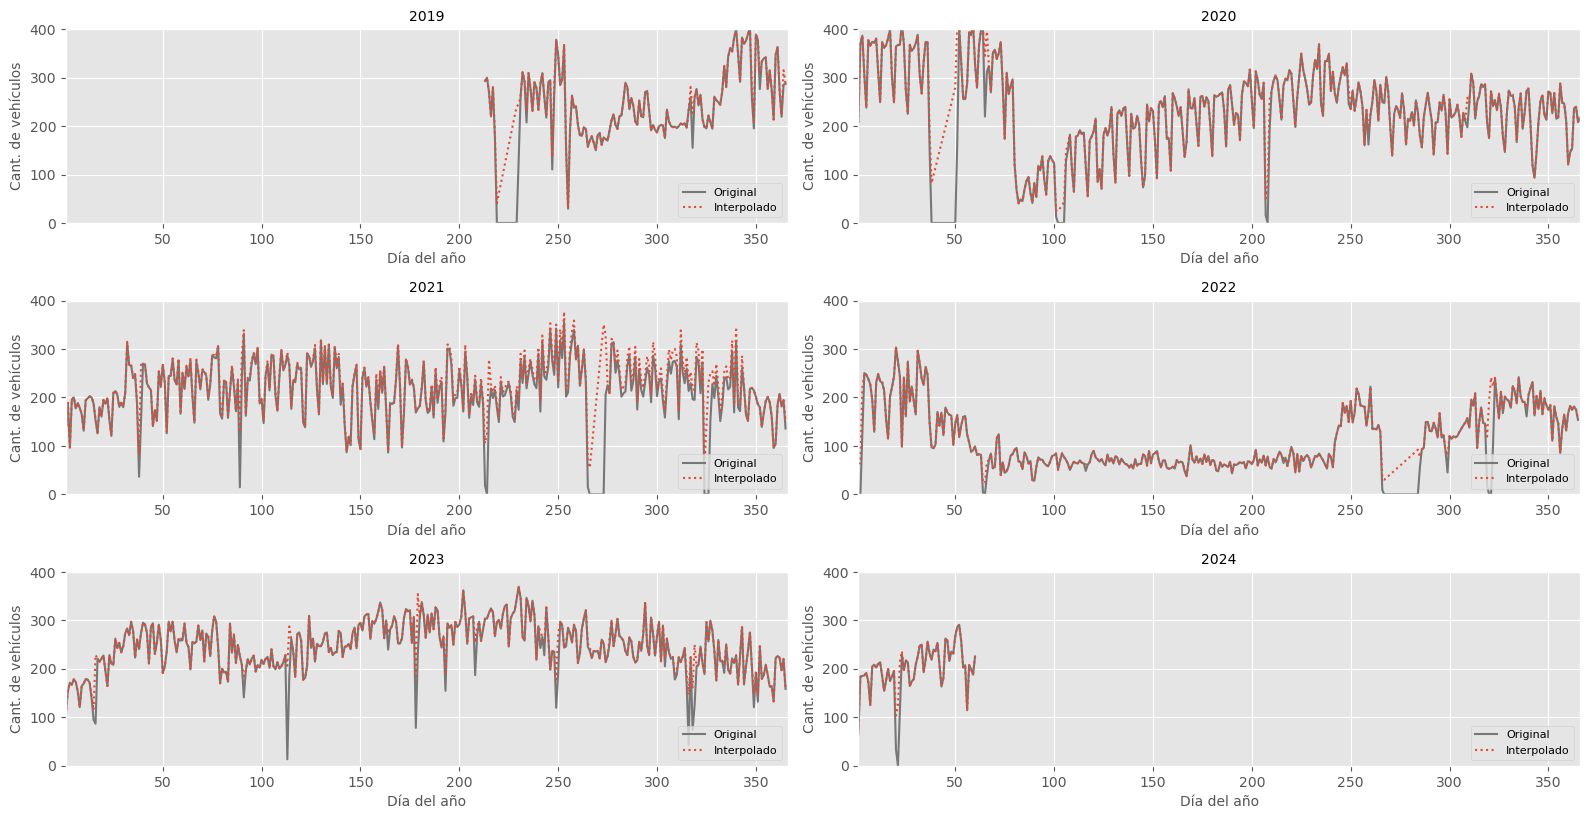

In [29]:
plt.figure(figsize=(16, 16))
for i, year in enumerate(range(2019, 2025)):
    plt.subplot(6, 2, i + 1)
    sns.lineplot(
        data=traffic_flow[traffic_flow.index.year == year],
        x=traffic_flow[traffic_flow.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Original',
        color=color[3]
        )
    sns.lineplot(
        data=traffic_flow_inter[traffic_flow_inter.index.year == year],
        x=traffic_flow_inter[traffic_flow_inter.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Interpolado',
        color=color[0],
        linestyle=':'
        )
    plt.ylim(0, 400)
    plt.xlim(1, 366)
    plt.ylabel('Cant. de vehículos', fontsize=10)
    plt.xlabel('Día del año', fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

    plt.title(f'{year}', fontsize=10)
plt.tight_layout()
plt.show()

Este método de imputación genera los valores faltantes uniendo los datos cercanos, generando escalones no muy uniformes pero no valores nulos aunque si menor a lo que se espera

## Resultados

Se pueden observar los distintos métodos de imputación comparados con el original

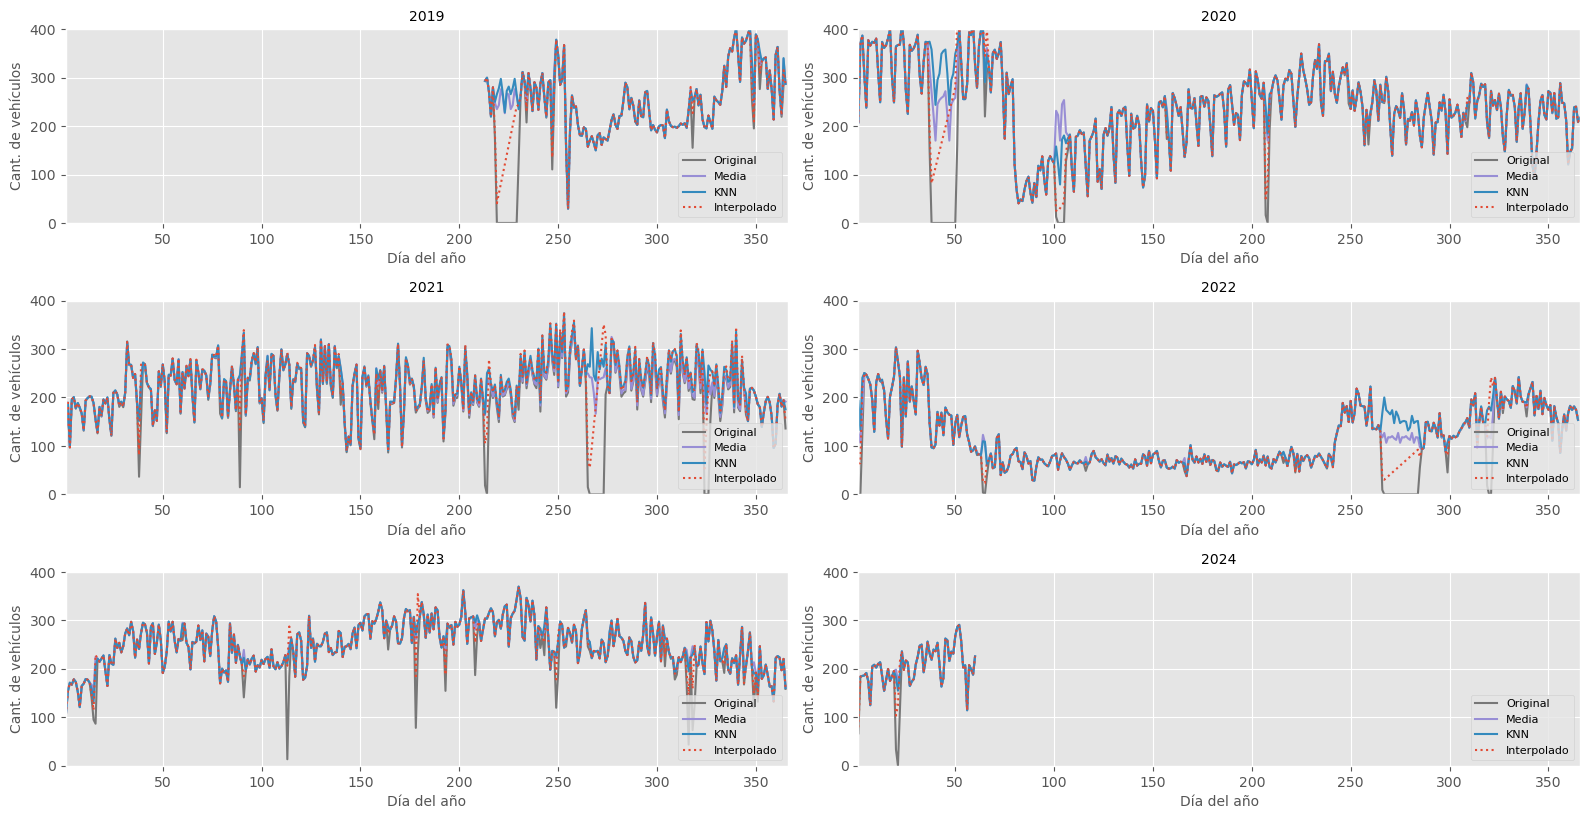

In [30]:
plt.figure(figsize=(16, 16))
for i, year in enumerate(range(2019, 2025)):
    plt.subplot(6, 2, i + 1)
    sns.lineplot(
        data=traffic_flow[traffic_flow.index.year == year],
        x=traffic_flow[traffic_flow.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Original',
        color=color[3]
        )
    sns.lineplot(
        data=traffic_flow_mean[traffic_flow_mean.index.year == year],
        x=traffic_flow_mean[traffic_flow_mean.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Media',
        color=color[2]
        )
    sns.lineplot(
        data=traffic_flow_knn[traffic_flow_knn.index.year == year],
        x=traffic_flow_knn[traffic_flow_knn.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='KNN',
        color=color[1]
        )
    sns.lineplot(
        data=traffic_flow_inter[traffic_flow_inter.index.year == year],
        x=traffic_flow_inter[traffic_flow_inter.index.year == year].index.dayofyear,
        y='traffic_flow',
        errorbar=None,
        label='Interpolado',
        color=color[0],
        linestyle=':'
        )
    plt.ylim(0, 400)
    plt.xlim(1, 366)
    plt.ylabel('Cant. de vehículos', fontsize=10)
    plt.xlabel('Día del año', fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

    plt.title(f'{year}', fontsize=10)
plt.tight_layout()
plt.savefig('cant_vehiculos.png', bbox_inches='tight', format='png', dpi=500)
plt.show()

Los datos a imputar son las lineas verticales que se ven que llegan hasta cero o cercano a cero. A primera vista se que **interpolar** no imputa los valores faltantes de forma uniforme y que ademas tiende a completar con valores cercanos a cero. En cambio los métodos **media** y **KNN** imputan los valores de forma más uniforme, siguiendo las tendencias de cada año. 

Con solo analizar los gráficos no se puede afirmar que método de imputación es mejor, recien se sabra cual es mejor cuando se entrene un ML.

Se selecciona el dataset con KNN para el siguiente desarrollo, pero se puede cambiar 

In [31]:
traffic_flow_to_merge = traffic_flow_knn.copy(deep=True)

## Más variables de interés

Para obtener más variables que nos ayuden en el entrenamiento de los futuros modelos, se decicio unir el dataset con los datos meteorológicos proporcionados por el [CIAL](https://cial.faudi.unc.edu.ar/). Cuenta con los siguientes datos:
- **Presión (bar)**: Presión atmosférica en bares
- **P (pressure)**: Presión del aire
- **P (altimeter)**: Presión para medir altitud
- **Temp in (ºC)**: Temperatura interior en °C
- **Temp out (ºC)**: Temperatura exterior en °C
- **HR in (%)**: Humedad relativa interior en %
- **HR out (%)**: Humedad relativa exterior en %
- **Vel viento (m/s)**: Velocidad del viento en m/s
- **Dir viento (0=N)**: Dirección del viento (0° = norte)
- **Vel racha**: Velocidad de ráfagas de viento
- **Dir racha**: Dirección de las ráfagas de viento
- **Tasa de lluvia**: Cantidad de lluvia por hora (mm/h)
- **Lluvia**: Total de lluvia caída (mm)
- **T rocio (ºC)**: Temperatura de rocío en °C
- **ST (ºC)**: Temperatura superficial en °C
- **IC**: Índice de confort térmico
- **ET**: Evapotranspiración, agua evaporada y transpirada
- **Rad (W/m²)**: Radiación solar en W/m²
- **UV**: Índice de radiación ultravioleta

Se carga el dataset con los datos meteorológicos

In [32]:
weather_df = pd.read_csv('Data/data-2019.08_2024.02-CIAL.csv', delimiter='|', skiprows=5, low_memory=False)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0    fecha - hora      132890 non-null  object 
 1    Presion (bar)     132890 non-null  object 
 2    P (pressure)      132890 non-null  object 
 3    P (altimeter)     132890 non-null  object 
 4    Temp in (ºC)      132890 non-null  float64
 5    Temp out (ºC)     132890 non-null  float64
 6    HR in (%)         132890 non-null  float64
 7    HR out (%)        132890 non-null  float64
 8    Vel viento (m/s)  132890 non-null  float64
 9    Dir viento (0=N)  132890 non-null  object 
 10   Vel racha         132890 non-null  float64
 11   Dir racha         132890 non-null  object 
 12   Tasa de lluvia    132890 non-null  float64
 13   LLuvia            132890 non-null  float64
 14   T rocio (ºC)      132890 non-null  float64
 15   ST (ºC)           132890 non-null  float64
 16   I

Se preprocesan los datos:
- Nuevo índice tipo `datetime`
- Eliminación de las últimas tres filas repetidas de presion, temperatura y humedad y Tx/Rx de datos
- Se cambiaron los nombres de las columnas por otros más sencillos
- Conversión de los valores `object` a `float`

In [33]:
def preprocess_weather(df):
    df = df.copy(deep=True)
    df.columns = df.columns.str.strip()
    df['fecha - hora'] = pd.to_datetime(df['fecha - hora'], format='%Y%m%d-%H:%M:%S')
    df.rename(columns={'fecha - hora': 'datetime'}, inplace=True)
    df.set_index('datetime', inplace=True)
    df.drop(columns=['Presion (bar)','P (altimeter)',
                     'Temp in (ºC)','HR in (%)','rxCheck',
                     'txBattStatus', 'ConsBattVoltage'], inplace=True)
    df = df.sort_index()
    df.rename(columns={'P (pressure)': 'presion', 'Temp out (ºC)': 'temp',
                       'HR out (%)': 'humedad', 'Vel viento (m/s)' : 'viento_vel',
                       'Dir viento (0=N)' : 'viento_dir', 'Tasa de lluvia': 'lluvia_tasa',
                       'Lluvia': 'lluvia', 'T rocio (ºC)': 'temp_rocio',
                       'ST (ºC)': 'st', 'IC': 'ic', 'ET': 'et', 'Rad (W/m^2)':'rad',
                       'UV': 'uv', 'Vel racha' : 'racha_vel',
                       'Dir racha':'racha_dir', 'LLuvia': 'lluvia'}, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

Se utiliza la función

In [34]:
weather_df = preprocess_weather(weather_df)

Se puede ver que el dataset original tiene más indices que el nuevo

In [35]:
print(f'Original:\t{traffic_flow_to_merge.shape[0]}')
print(f'Nuevo:\t\t{weather_df.shape[0]}')

Original:	160699
Nuevo:		132890


Se mantendra la cantidad de índices del dataset original y solo se uniran aqullos índices que coinciden

In [36]:
merged_df = pd.merge(traffic_flow_to_merge, weather_df, left_index=True, right_index=True, how='left')

La cantidad de valores nulos son

In [37]:
merged_df.isna().sum()

year                 0
month                0
day                  0
day_of_year          0
day_of_week          0
hour                 0
minute               0
period_of_day        0
traffic_flow         0
presion          29654
temp             27809
humedad          27809
viento_vel       27809
viento_dir       72445
racha_vel        27809
racha_dir        38626
lluvia_tasa      27809
lluvia           27809
temp_rocio       27809
st               27809
ic               27809
et               27809
rad              27809
uv               27809
dtype: int64

Se puede observa que faltan datos correspondientes con ciertas fechas. Una solución es completar los datos faltantes con la media de los mismos

In [38]:
merged_df_mean = merged_df.fillna(merged_df.select_dtypes(exclude=['object']).mean())

Se puede observar los datos estadisticos antes y despues de imputar

In [39]:
merged_df.select_dtypes(exclude=['object']).describe()

,year,month,day,day_of_year,day_of_week,hour,minute,traffic_flow,presion,temp,humedad,viento_vel,viento_dir,racha_vel,racha_dir,lluvia_tasa,lluvia,temp_rocio,st,ic,et,rad,uv
count,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.00000,160699.000000,131045.000000,132890.000000,132890.000000,132890.000000,88254.000000,132890.000000,122073.000000,132890.000000,132890.000000,132890.000000,132890.000000,132890.000000,132890.000000,132890.000000,132890.000000
mean,2021.360257,6.660029,15.728660,187.329398,3.000050,10.726607,22.49958,214.933787,960.369654,18.490390,51.603477,1.078013,104.529110,3.210293,117.381288,0.000113,0.000064,6.963177,18.478113,64.411383,0.001428,160.690368,2.360801
std,1.366463,3.545407,8.799431,108.322424,1.999415,7.079469,16.77052,140.498498,13.474448,7.059237,21.330490,3.533837,78.505139,4.670105,91.746915,0.004196,0.000847,7.634274,7.081643,13.250873,0.005410,254.823433,3.476777
min,2019.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,838.410000,-1.800000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.700000,-4.000000,28.800000,0.000000,0.000000,0.000000
25%,2020.000000,3.000000,8.000000,90.000000,1.000000,4.000000,7.50000,97.000000,957.090000,13.200000,35.000000,0.000000,45.000000,1.300000,45.000000,0.000000,0.000000,1.300000,13.200000,54.270000,0.000000,0.000000,0.000000
50%,2021.000000,7.000000,16.000000,195.000000,3.000000,10.000000,15.00000,197.000000,961.180000,18.500000,50.000000,0.400000,67.500000,2.200000,90.000000,0.000000,0.000000,7.400000,18.500000,64.510000,0.000000,0.000000,0.000000
75%,2023.000000,10.000000,23.000000,282.000000,5.000000,17.000000,30.00000,312.800000,965.440000,23.600000,67.000000,1.300000,180.000000,4.500000,180.000000,0.000000,0.000000,13.000000,23.600000,74.190000,0.000000,266.000000,4.600000
max,2024.000000,12.000000,31.000000,366.000000,6.000000,23.000000,45.00000,755.000000,1047.710000,41.700000,100.000000,43.400000,337.500000,43.800000,355.000000,0.709000,0.063000,25.200000,41.700000,108.170000,0.255000,1192.000000,15.900000


In [40]:
merged_df_mean.select_dtypes(exclude=['object']).describe()

,year,month,day,day_of_year,day_of_week,hour,minute,traffic_flow,presion,temp,humedad,viento_vel,viento_dir,racha_vel,racha_dir,lluvia_tasa,lluvia,temp_rocio,st,ic,et,rad,uv
count,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.00000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.00000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000,160699.000000
mean,2021.360257,6.660029,15.728660,187.329398,3.000050,10.726607,22.49958,214.933787,960.369654,18.490390,51.603477,1.078013,104.52911,3.210293,117.381288,0.000113,0.000064,6.963177,18.478113,64.411383,0.001428,160.690368,2.360801
std,1.366463,3.545407,8.799431,108.322424,1.999415,7.079469,16.77052,140.498498,12.167863,6.419439,19.397248,3.213556,58.17784,4.246840,79.963955,0.003816,0.000770,6.942358,6.439813,12.049909,0.004920,231.728069,3.161667
min,2019.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,838.410000,-1.800000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-16.700000,-4.000000,28.800000,0.000000,0.000000,0.000000
25%,2020.000000,3.000000,8.000000,90.000000,1.000000,4.000000,7.50000,97.000000,958.100000,14.300000,38.000000,0.000000,67.50000,1.300000,67.500000,0.000000,0.000000,2.600000,14.300000,56.430000,0.000000,0.000000,0.000000
50%,2021.000000,7.000000,16.000000,195.000000,3.000000,10.000000,15.00000,197.000000,960.369654,18.490390,51.603477,0.900000,104.52911,2.700000,117.381288,0.000000,0.000000,6.963177,18.478113,64.411383,0.000000,39.000000,0.000000
75%,2023.000000,10.000000,23.000000,282.000000,5.000000,17.000000,30.00000,312.800000,964.300000,22.500000,63.000000,1.078013,104.52911,3.600000,157.500000,0.000000,0.000000,11.900000,22.500000,72.100000,0.001428,166.000000,3.900000
max,2024.000000,12.000000,31.000000,366.000000,6.000000,23.000000,45.00000,755.000000,1047.710000,41.700000,100.000000,43.400000,337.50000,43.800000,355.000000,0.709000,0.063000,25.200000,41.700000,108.170000,0.255000,1192.000000,15.900000


Se puede obtener la correlación entre `traffic_flow` y las demas columnas

In [41]:
for period in merged_df['period_of_day'].unique():
    print(f'Correlación para {period}')
    print(merged_df[merged_df.period_of_day == period].drop(columns=['year', 'month', 'day', 'period_of_day', 'day_of_year', 'day_of_week']).corrwith(merged_df['traffic_flow']).sort_values(ascending=False))

Correlación para noche
traffic_flow    0.744314
temp            0.071226
st              0.070987
ic              0.069315
temp_rocio      0.037936
minute          0.008919
lluvia          0.006154
viento_dir      0.001110
et             -0.002513
racha_dir      -0.002804
racha_vel      -0.006473
lluvia_tasa    -0.008536
viento_vel     -0.015101
humedad        -0.018408
presion        -0.032308
hour           -0.108551
rad                  NaN
uv                   NaN
dtype: float64
Correlación para madrugada


c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


traffic_flow    0.579640
st              0.070522
temp            0.069475
ic              0.049349
lluvia          0.036090
presion         0.035813
lluvia_tasa     0.020283
rad             0.013412
minute          0.004339
temp_rocio      0.000274
et             -0.007929
viento_dir     -0.033426
racha_dir      -0.033539
racha_vel      -0.055235
viento_vel     -0.071369
humedad        -0.075780
hour           -0.150058
uv                   NaN
dtype: float64
Correlación para mañana
traffic_flow    0.800062
uv              0.124582
rad             0.110341
hour            0.106897
ic              0.097238
st              0.084132
temp            0.083996
temp_rocio      0.053569
racha_vel       0.027130
et              0.021548
viento_dir      0.018532
viento_vel      0.017533
lluvia_tasa     0.012714
lluvia          0.012445
racha_dir       0.001443
humedad        -0.011153
minute         -0.013626
presion        -0.030299
dtype: float64
Correlación para siesta
traffic_flow    0.7855

c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


También se puede generar una matriz de correlacion donde se observa más fácil cada variable 

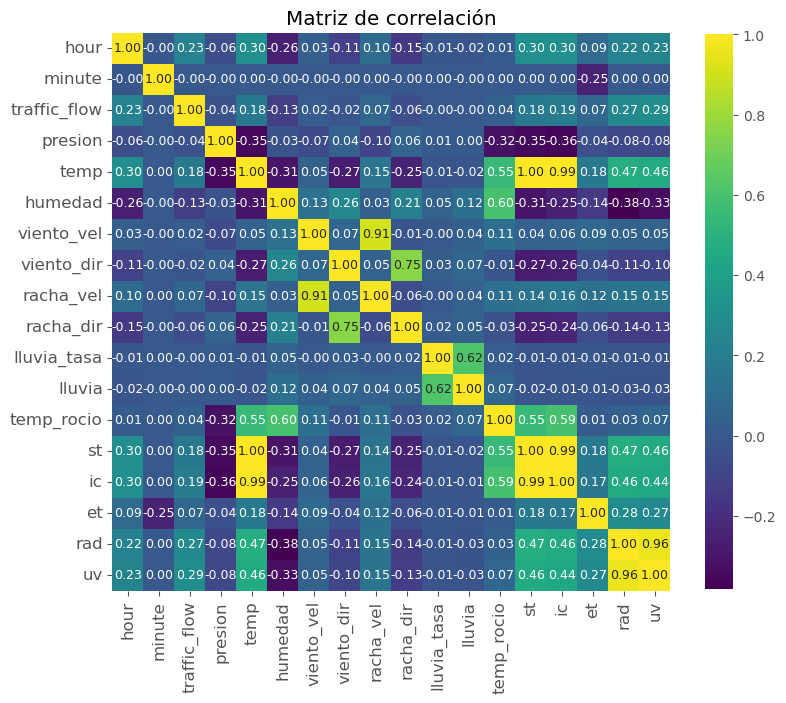

In [46]:
corr = merged_df.drop(columns=['year', 'month', 'day', 'period_of_day', 'day_of_year', 'day_of_week']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(9, 9))
sns.heatmap(data=corr, annot=True, fmt='.2f', square = True, annot_kws={"size": 9}, cbar_kws={'shrink': 0.8}, cmap='viridis')
plt.title('Matriz de correlación')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Exportación de los datos

Una vez elegido el metodo para imputar los datos faltantes, se crea una función que codifica la variable `period_of_day` con el método de `.get_dummies` y luego estandarizar los valroes mediante `StandardScaler()`

In [43]:
def encoder_scaler(df):
    df = df.copy(deep=True)
    cols = df.columns.tolist()
    scaler = StandardScaler() # DIstribucion normal
    df = pd.get_dummies(df, columns=['period_of_day'], prefix='period_of_day')
    # Se aplica StandardScaler a TODAS las columnas
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Se aplica la función y se guarda el archivo con el nombre `output_eda.csv`

In [44]:
traffic_flow_eda = encoder_scaler(merged_df)
traffic_flow_eda.to_csv('output_eda.csv')